# Model

In [13]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
from xgboost import plot_importance
# pip install pandas numpy scikit-learn imblearn xgboost matplotlib joblib

In [14]:
import sys
import os
root_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if root_path not in sys.path:
    sys.path.append(root_path)
from fileDir import getDataDir, getModelDir, getPredDir

In [ ]:
df = pd.read_csv(getDataDir("train",1))

Define target and features

In [16]:
target = "default_12month"
X = df.drop(columns=[target])
y = df[target]

Handle categorical variables

In [17]:
# Use one-hot encoding for categorical features (e.g., gender, marital_status, apply)
X = pd.get_dummies(X, drop_first=True)

Save feature names before scailing

In [18]:
feature_names = X.columns.tolist()
joblib.dump(feature_names, getModelDir("feature", 1, "xgboost"))

['../../model/v1/train_features_model_xgboost.pkl']

Split into training and testing sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Normalize numeric features

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Save the scaler

In [21]:
joblib.dump(scaler, getModelDir("scaler", 1, "xgboost"))

['../../model/v1/scaler_model_xgboost.pkl']

Handle Class Imbalance (SMOTE)

In [22]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

Hyperparameter Tuning (Using: XGBoost)

In [23]:
param_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [10],
    "learning_rate": [0.001, 0.015, 0.02],
    "subsample": [0.8, 0.9, 1.0], # bound [0,1]
    "colsample_bytree": [0.8, 0.9, 1.0], # bound [0,1]
    "min_child_weight": [0.4, 0.5, 0.6],
    "gamma": [0.2, 0.25, 0.3],
}

base_model = XGBClassifier(
    eval_metric="logloss",
    random_state=42,
    use_label_encoder=False,
)

search = RandomizedSearchCV(
    base_model,
    param_distributions=param_grid,
    n_iter=25,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

print("Tuning hyperparameters...")
search.fit(X_train_res, y_train_res)
best_model = search.best_estimator_

print("Best Parameters Found:", search.best_params_)

Tuning hyperparameters...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


/opt/miniconda3/envs/aihack/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:51:33] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/aihack/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:51:33] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/aihack/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:51:33] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj

Best Parameters Found: {'subsample': 0.9, 'n_estimators': 400, 'min_child_weight': 0.4, 'max_depth': 10, 'learning_rate': 0.02, 'gamma': 0.3, 'colsample_bytree': 1.0}


Evaluate Model

In [24]:
y_proba = best_model.predict_proba(X_test)[:, 1]

# Automatically find the best threshold based on F1
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_threshold = thresholds[np.argmax(f1_scores)]

y_pred = (y_proba >= best_threshold).astype(int)

print("\nOptimal Threshold:", round(best_threshold, 3))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


Optimal Threshold: 0.151

Confusion Matrix:
[[3769 1894]
 [ 399  443]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.67      0.77      5663
           1       0.19      0.53      0.28       842

    accuracy                           0.65      6505
   macro avg       0.55      0.60      0.52      6505
weighted avg       0.81      0.65      0.70      6505

ROC-AUC Score: 0.6283887198772882


Save model

In [26]:
joblib.dump(best_model, getModelDir("model", 1, "xgboost"))

['../../model/v1/model_xgboost.pkl']

Feature Importance

<Figure size 1000x600 with 0 Axes>

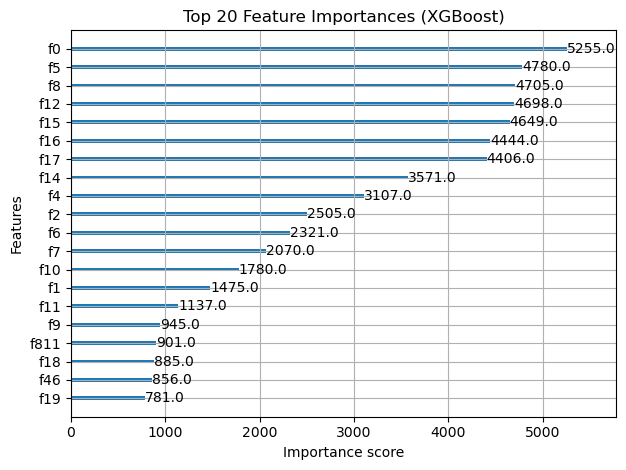


Model saved successfully as model_v0.pkl


In [27]:
plt.figure(figsize=(10, 6))
plot_importance(best_model, max_num_features=20)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

print("\nModel saved successfully as model_v0.pkl")